In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import numpy as onp
import jax
import jax.numpy as np

from jax import lax, random
from jax.api import grad, jit, vmap
from jax.config import config
from jax.experimental import optimizers
from jax.experimental.stax import logsoftmax

config.update('jax_enable_x64', True)

from neural_tangents import stax

from functools import partial

# Attacking
from cleverhans.utils import clip_eta, one_hot

# Plotting
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import *

sns.set_style(style='white')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

"""
diag_reg:
    a scalar representing the strength of the diagonal regularization for
    `k_train_train`, i.e. computing `k_train_train + diag_reg * I` during
    Cholesky factorization or eigendecomposition.
"""
diag_reg = 1e-5

# data

In [2]:
DATASET = 'cifar10'
class_num   = 10
image_shape = None

train_size = None
test_size = 2048
test_batch_size = 1
eps = 0.03

if DATASET =='mnist':
    image_shape = (28, 28, 1)
elif DATASET == 'cifar10':
    image_shape = (32, 32, 3)

In [3]:
x_train_all, y_train_all, x_test_all, y_test_all = tuple(onp.array(x) for x in get_dataset(DATASET, None, None, 
                                                                                  do_flatten_and_normalize=False))

In [4]:
# shuffle
seed = 0
x_train_all, y_train_all = shaffle(x_train_all, y_train_all, seed)

In [5]:
# down sample
x_train = x_train_all[:train_size]
y_train = y_train_all[:train_size]

x_test = x_test_all[:test_size]
y_test = y_test_all[:test_size]

In [6]:
x_train, x_test = x_train.reshape((-1, *image_shape)), x_test.reshape((-1, *image_shape))

# model

In [7]:
def correct(mean, ys):
    return onp.argmax(mean, axis=-1) == onp.argmax(ys, axis=-1)

In [8]:
def ConvBlock(channels, W_std, b_std, strides=(1,1)):
    return stax.serial(stax.Conv(out_chan=channels, filter_shape=(3,3), strides=strides, padding='SAME',
                                 W_std=W_std, b_std=b_std), 
                       stax.Relu(do_backprop=True))

def ConvGroup(n, channels, stride, W_std, b_std, last_stride=False):
    blocks = []
    if last_stride:
        for i in range(n-1):
            blocks += [ConvBlock(channels, W_std, b_std, stride)]
        blocks += [ConvBlock(channels, W_std, b_std, (2, 2))]
    
    else:
        for i in range(n):
            blocks += [ConvBlock(channels, W_std, b_std, stride)]
        
    return stax.serial(*blocks)
        
def VGG19(class_num=class_num):
    return stax.serial(
        ConvGroup(n=2, channels=64 , stride=(1,1), W_std=1.414, b_std=0.18, last_stride=False),
        ConvGroup(n=2, channels=128, stride=(1,1), W_std=1.414, b_std=0.18, last_stride=False),
        ConvGroup(n=4, channels=256, stride=(1,1), W_std=1.414, b_std=0.18, last_stride=False),
        ConvGroup(n=4, channels=512, stride=(1,1), W_std=1.414, b_std=0.18, last_stride=False),
        ConvGroup(n=4, channels=512, stride=(1,1), W_std=1.414, b_std=0.18, last_stride=False),
        stax.Flatten(),
        stax.Dense(512), stax.Relu(do_backprop=True),
        stax.Dense(class_num))

def simple_net(class_num=class_num):
    return stax.serial(
        ConvGroup(n=3, channels=64 , stride=(1,1), W_std=1.414, b_std=0.18, last_stride=False),
        stax.Flatten(),
        stax.Dense(512, W_std=1.414), stax.Relu(do_backprop=True),
        stax.Dense(class_num, W_std=1.414))

In [9]:
init_fn, apply_fn, kernel_fn = VGG19(class_num)

In [10]:
batch_kernel_fn = nt.batch(kernel_fn, batch_size=256, store_on_device=False)

In [11]:
# kernel_train_m = batch_kernel_fn(x_train, None, 'ntk')

In [12]:
# predict_fn = nt.predict.gradient_descent_mse(kernel_train_m, y_train, diag_reg=diag_reg)
# kernel_test_train = kernel_fn(x_test, x_train, 'ntk')
# pred = predict_fn(None, 0, 0 , kernel_test_train)
# ans = onp.argmax(pred[1], axis=1)==onp.argmax(y_test, axis=1)

# print("testing accuracy: %.4f"%(sum(ans)/ans.shape[0]))

# plt.figure(dpi=100)
# plt.imshow(kernel_train_m[:128, :128])

In [13]:
def model_fn(kernel_fn, x_train=None, x_test=None, fx_train_0=0., fx_test_0=0., t=None, ntk_train_train=None):
    # Kernel
    if ntk_train_train is None:
        ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    
    ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
    # Prediction
    predict_fn = nt.predict.gradient_descent_mse(ntk_train_train, y_train, diag_reg=diag_reg) # no convariance
    
    return predict_fn(t, fx_train_0, fx_test_0, ntk_test_train) # fx_train_0, fx_test_0 = (0, 0) for infinite width

# loss

In [14]:
@jit
def l2_loss_v1(logits, labels, weighting=1):
    """
    Tensorflow version of L2 loss (without sqrt)
    """
    return np.sum(((logits - labels)**2) * weighting) / 2
    
@jit
def l2_loss_v2(logits, lables):
    """
    Normal L2 loss
    """
    return np.linalg.norm(logits - labels)

@jit
def cross_entropy_loss(logits, lables):
    return -np.sum(logsoftmax(logits) * lables)
    
@jit
def mse_loss(logits, lables):
    return 0.5 * np.mean((logits - lables) ** 2)

# attack algorithms

In [15]:
def fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, x_train=None, y_train=None, x_test=None, 
                         y=None, t=None, loss_weighting=None, fx_train_0=0., fx_test_0=0., eps=0.3, 
                         norm=np.inf, clip_min=None, clip_max=None, targeted=False):
    
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")
        
    x = x_test
        
    # test independent
    if obj_fn == 'untargeted':
        grads = grads_fn(x_train, x_test, y_train, y, kernel_fn, t)
        
    else:
        raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")

    axis = list(range(1, len(grads.shape)))
    eps_div = 1e-12
    
    if norm == np.inf:
        perturbation = eps * np.sign(grads)
    elif norm == 1:
        raise NotImplementedError("L_1 norm has not been implemented yet.")
    elif norm == 2:
        square = np.maximum(eps_div, np.sum(np.square(grads), axis=axis, keepdims=True))
        perturbation = grads / np.sqrt(square)
    
    adv_x = x + perturbation
    
    # If clipping is needed, reset all values outside of [clip_min, clip_max]
    if (clip_min is not None) or (clip_max is not None):
        # We don't currently support one-sided clipping
        assert clip_min is not None and clip_max is not None
        adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
    
    return adv_x

In [16]:
def fast_gradient_method_batch(model_fn, kernel_fn, obj_fn, grads_fn, ntk_train_train, x_train=None, y_train=None, 
                               x_test=None, y=None, t=None, loss_weighting=None, fx_train_0=0., fx_test_0=0., eps=0.3, 
                               norm=np.inf, clip_min=None, clip_max=None, targeted=False):
    
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")
        
    x = x_test
        
    # test independent
    if obj_fn == 'untargeted':
        grads = grads_fn(x_train, x_test, y_train, y, kernel_fn, ntk_train_train, t)
        
    else:
        raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")

    axis = list(range(1, len(grads.shape)))
    eps_div = 1e-12

    return grads

In [17]:
def iter_fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, x_train=None, y_train=None,
                               x_test=None, y=None, t=None, loss_weighting=None, fx_train_0=0., fx_test_0=0., 
                               eps=0.3, eps_iter=0.03, nb_iter=10, norm=np.inf, clip_min=None, clip_max=None, 
                               targeted=False, rand_init=None, rand_minmax=0.3):

    assert eps_iter <= eps, (eps_iter, eps)
    if norm == 1:
        raise NotImplementedError("It's not clear that FGM is a good inner loop"
                                  " step for PGD when norm=1, because norm=1 FGM "
                                  " changes only one pixel at a time. We need "
                                  " to rigorously test a strong norm=1 PGD "
                                  "before enabling this feature.")
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")
        
    x = x_test
    
    # Initialize loop variables
    if rand_init:
        rand_minmax = eps
        eta = random.uniform(new_key, x.shape, minval=-rand_minmax, maxval=rand_minmax)
    else:
        eta = np.zeros_like(x)

    # Clip eta
    eta = clip_eta(eta, norm, eps)
    adv_x = x + eta
    if clip_min is not None or clip_max is not None:
        adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
        
    for i in range(nb_iter):
        adv_x = fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, x_train, y_train, adv_x, 
                                        y, t, loss_weighting, fx_train_0, fx_test_0, eps_iter, norm, 
                                        clip_min, clip_max, targeted)

        # Clipping perturbation eta to norm norm ball
        eta = adv_x - x
        eta = clip_eta(eta, norm, eps)
        adv_x = x + eta

        # Redo the clipping.
        # FGM already did it, but subtracting and re-adding eta can add some
        # small numerical error.
        if clip_min is not None or clip_max is not None:
            adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
    
    return adv_x

# Attack Hyperparameters

In [18]:
if DATASET == 'mnist':
    eps = 0.3
    eps_iter_10 = (eps/10)*1.1
    eps_iter_100 = (eps/100)*1.1
    eps_iter_1000 = (eps/1000)*1.1
    
elif DATASET == 'cifar10':
    eps = 0.03
    eps_iter_10 = (eps/10)*1.1
    eps_iter_100 = (eps/100)*1.1

In [19]:
def evaluate_accuracy(x_train, x_test, y_test, model_fn, kernel_fn, t=None, attack_type=None, ntk_train_train=None):
    
    y_train_predict, y_test_predict = model_fn(kernel_fn, x_train, x_test, 
                                               t=t, ntk_train_train=ntk_train_train)
    
    selected_table = correct(y_test_predict, y_test)
    print("Accuray({:s}): {:.2f}".format(attack_type, onp.mean(selected_table)))
    
    return selected_table

In [20]:
def evaluate_robustness(x_train, x_test, y_test, model_fn, kernel_fn, selected_table, t=None, 
                        attack_type=None, ntk_train_train=None):
    
    y_train_predict, y_test_predict = model_fn(kernel_fn, x_train, x_test,
                                               t=t, ntk_train_train=ntk_train_train)
    
    y_test_predict = onp.asarray(y_test_predict)
    y_test_predict_select = y_test_predict[onp.asarray(selected_table)]
    y_test_select = y_test[onp.asarray(selected_table)]
    print("Robustness({:s}): {:.2f}".format(attack_type, onp.mean(correct(y_test_predict_select, y_test_select))))
    
    return

# adv_x generation

In [21]:
def inv(k):
        #inverse with diag_reg
        return onp.linalg.inv(k + diag_reg * onp.eye(k.shape[0]))

In [22]:
# kernel_train_inv_m = inv(kernel_train_m)

In [23]:
def test_loss_adv_mse(x_train, x_test, y_train, y, kernel_fn, ntk_train_train, t=None, diag_reg=diag_reg):

        ntk_test_train = kernel_fn(x_test[None], x_train, 'ntk')

        predict_fn = nt.predict.gradient_descent_mse(ntk_train_train, y_train, diag_reg=diag_reg)
        # predict_fn(t, train_0, test_0, kernel_matrix)
        pred = predict_fn(t, 0., 0., ntk_test_train)[1]

        # loss = -mse_loss(pred, y)
        loss = -np.sum(logsoftmax(pred) * y)
        return loss

test_mse_grads_fn = jit(vmap(grad(test_loss_adv_mse, argnums=1), in_axes=(None, 0, None, 0, None, None, None), 
                             out_axes=0), static_argnums=(4,))

In [24]:
def gen_adv_x(kernel_fn, x_train, x_test, y_test, t=None, train_batch=256):
    
    
    # for building matrix
    kernel_fn = jit(kernel_fn, static_argnums=(2,))
    
    def inv(k):
        #inverse with diag_reg
        return onp.linalg.inv(k + diag_reg * onp.eye(k.shape[0]))
    
    num_iter = x_train.shape[0] // train_batch
    
    grads = 0
    # print('generating FGSM data...')
    for idx in range(num_iter):
        
        x_train_batch = x_train[idx*train_batch: (idx+1)*train_batch]
        y_train_batch = y_train[idx*train_batch: (idx+1)*train_batch]
        
        ntk_train_train     = kernel_fn(x_train_batch, None, 'ntk')
        # ntk_train_train_inv = inv(ntk_train_train)
    
        # FGSM
        grads += fast_gradient_method_batch(model_fn=model_fn, kernel_fn=kernel_fn, obj_fn='untargeted', 
                                           grads_fn=test_mse_grads_fn, x_train=x_train_batch, y_train=y_train_batch, 
                                           x_test=x_test, y=y_test, t=t, eps=eps, clip_min=0, clip_max=1, ntk_train_train=ntk_train_train)
    
    perturbation = eps * np.sign(grads)
    adv_x_FGSM = x_test + perturbation
    adv_x_FGSM = np.clip(adv_x_FGSM, a_min=0, a_max=1)
    
    
    # clean
    # print('evaluateing clean...')
    # selected_table = evaluate_accuracy(x_train, x_test, y_test, model_fn=model_fn,
    #                                   kernel_fn=kernel_fn, t=t, attack_type='Clean', ntk_train_train=ntk_train_train)

    
    # print('evaluateing FGSM...')
    # evaluate_accuracy(x_train, adv_x_FGSM, y_test, model_fn=model_fn,
    #                    kernel_fn=kernel_fn, t=t, attack_type='FGSM', ntk_train_train=ntk_train_train)
    
    # evaluate_robustness(x_train, adv_x_FGSM, y_test, model_fn=model_fn,
    #                    kernel_fn=kernel_fn, selected_table=selected_table, t=t, 
    #                    attack_type='FGSM', ntk_train_train=ntk_train_train)

    return adv_x_FGSM

In [25]:
# time opt: 131072
time = [None]

In [26]:
from tqdm import tqdm

In [ ]:
adv_x_FGSM, adv_x_IFGSM_100 = {}, {}
for t in time:
    adv_x_FGSM[t] = []
    adv_x_IFGSM_100[t] = []
    print("generating time:", t)
    
    for batch_id in tqdm(range(test_size//test_batch_size)):
        fgsm = gen_adv_x(kernel_fn,
                         x_train,
                         x_test[batch_id*test_batch_size:(batch_id+1)*test_batch_size], 
                         y_test[batch_id*test_batch_size:(batch_id+1)*test_batch_size],
                         t)
        
        adv_x_FGSM[t].append(fgsm)
        # adv_x_IFGSM_100[t].append(ifgsm)
        if batch_id % 5 == 0:
            onp.save('./batch_NTK_vgg', onp.asarray(adv_x_FGSM[t]))


  0%|          | 0/2048 [00:00<?, ?it/s]

generating time: None



  7%|▋         | 139/2048 [3:56:20<54:10:30, 102.16s/it]


 13%|█▎        | 275/2048 [7:47:53<50:18:56, 102.16s/it]


 18%|█▊        | 370/2048 [10:29:32<47:43:37, 102.39s/it]

In [52]:
onp.save('./batch_NTK_vgg', tmp)

In [25]:
for t in time:
    onp.save('cifar-fgsm-eps-%.2f-time-%s-init-9.npy'%(eps, str(t)), onp.concatenate(adv_x_FGSM[t]))
    # onp.save('cifar-ifgsm-eps-%.2f-time-%s-init.npy'%(eps, str(t)), onp.concatenate(adv_x_IFGSM_100[t]))

In [38]:
onp.save('cifar-clean.npy', x_test)

In [57]:
def plt_samples(arr, attack_type, layer):
    fig, axs = plt.subplots(2, 4, figsize=(6, 3), sharex=True)
    for row, ax in enumerate(axs):
        for idx, a in enumerate(ax):
            img = arr[idx + row*4].reshape(image_shape)
            a.axis('off')
            a.xaxis.set_visible(False)
            a.yaxis.set_visible(False)
            a.imshow(img, cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

In [58]:
def save_samples(arr, attack_type, layer):
    fig, axs = plt.subplots(2, 4, figsize=(6, 3), sharex=True)
    for row, ax in enumerate(axs):
        for idx, a in enumerate(ax):
            img = arr[idx + row*4].reshape(image_shape)
            a.axis('off')
            a.xaxis.set_visible(False)
            a.yaxis.set_visible(False)
            a.imshow(img, cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.savefig("./fig-%s-untargeted/%s_layer_%d.png"%(DATASET ,attack_type, layer+1), dpi=150)
    plt.show()

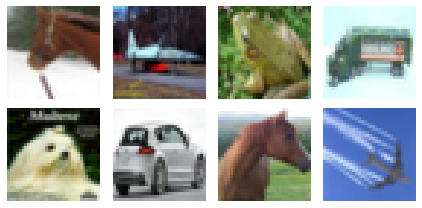

In [59]:
plt_samples(x_test, 'clean', 0)

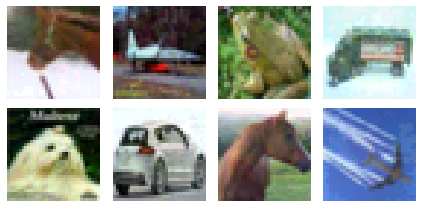

In [60]:
plt_samples(tmp, 'clean', 0)